In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install transformers accelerate
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, AutoModelForSequenceClassification, AutoConfig,Trainer, TrainingArguments,DataCollatorWithPadding
import torch
import numpy as np
import pandas as pd
# !pip install datasets
from datasets import load_metric
# !pip install evaluate
# 
from sklearn.model_selection import train_test_split
import csv
import whatthepatch
import evaluate

In [3]:
df = pd.read_csv(r'/root/autodl-tmp/ensemble-commit/dataset/dataset.csv', index_col=0, encoding='utf_8_sig')
df.fillna('', inplace=True)
label2id={'negative':0,'positive':1}
df = df.replace({"label": label2id})
df

/tmp/ipykernel_2644/1486535216.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({"label": label2id})


,label,message,diff
0,0,Merge pull request #46 from rufferson/saslx-tl...,diff --git a/lib/DJabberd.pm b/lib/DJabberd.pm...
1,1,Fix leaks in kadmin server stubs [CVE-2015-863...,diff --git a/src/kadmin/server/server_stubs.c ...
2,1,Validate authorization request on approval\n\n...,diff --git a/spring-security-oauth2/src/main/j...
3,1,Release 2.72.4+171110,diff --git a/application/config/version.php b/...
4,0,Fixing compiler warnings.,diff --git a/src/main.c b/src/main.c\nindex 50...
...,...,...,...
10107,0,les: remove useless protocol defines (#22115)\...,diff --git a/les/benchmark.go b/les/benchmark....
10108,1,Merge pull request #2067 from realm/tg-swift-l...,diff --git a/CHANGELOG.md b/CHANGELOG.md\ninde...
10109,0,[fix] 新規アカウント作成ページの翻訳を修正,diff --git a/app/locales/ja_JP/LC_MESSAGES/mes...
10110,0,Merge branch 'hotfixes',diff --git a/CHANGELOG.txt b/CHANGELOG.txt\nin...


In [4]:
def find_longest_list(lists):
    # print(lists)
    if not lists:
        return None
    try:
        longest_list = max(lists, key=len)
    except:
        longest_list = None
    return longest_list

In [5]:
def extract_lines(changes):
    try:
       res = ''.join([x.line for x in changes])
    except:
       res = None
    return res

In [6]:
df['command'] = df['diff'].apply(lambda x : extract_lines(find_longest_list([y.changes for y in whatthepatch.parse_patch(x)])))

In [7]:
train, test = train_test_split(df,train_size=0.7,stratify=df['label'],random_state=1)

In [8]:
# from transformers import RobertaModel, 
from transformers import AutoModelForSequenceClassification,   TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained('/root/autodl-tmp/models/codebert-base')
tokenizer = AutoTokenizer.from_pretrained('/root/autodl-tmp/models/codebert-base')

Some weights of the model checkpoint at /root/autodl-tmp/models/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /root/autodl-tmp/models/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model 

In [9]:
training_args = TrainingArguments(
    output_dir="./my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [10]:
encoded_train = tokenizer(train['command'].astype(str).to_list(), return_tensors='pt',truncation=True, padding=True)
encoded_test = tokenizer(test['command'].astype(str).to_list(), return_tensors='pt',truncation=True, padding=True)

In [11]:
class CommitDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [12]:
train_dataset = CommitDataset(encoded_train, list(train['label']))
test_dataset = CommitDataset(encoded_test, list(test['label']))

In [13]:
def compute_metrics(eval_pred):
    accuracy = evaluate.load('/root/autodl-tmp/evaluate/metrics/accuracy')
    precision =  evaluate.load("/root/autodl-tmp/evaluate/metrics/precision")
    recall =  evaluate.load("/root/autodl-tmp/evaluate/metrics/recall")
    f1 =  evaluate.load("/root/autodl-tmp/evaluate/metrics/f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy.compute(predictions=predictions, references=labels)
    precision = precision.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall.compute(predictions=predictions, references=labels,average='weighted')
    f1 = f1.compute(predictions=predictions, references=labels,average='weighted')
    # accuracy_score = metrics.accuracy_score(labels,predictions)
    # precision_score = metrics.precision_score(labels,predictions, average='weighted')
    # recall_score = metrics.recall_score(labels,predictions,average='weighted')
    # f1_score = metrics.f1_score(labels,predictions,average='weighted')

    # return {"classification_report": classification_report}
    # return {"precision": precision_score,"recall": recall_score, "f1":f1_score, "accuracy": accuracy_score}
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [14]:
# !export https_proxy=http://turbo.gpushare.com:30000 http_proxy=http://turbo.gpushare.com:30000
# !export https_proxy=http://turbo2.gpushare.com:30000 http_proxy=http://turbo2.gpushare.com:30000

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

result = trainer.train()

/root/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_2644/77294352.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.691074,{'precision': 0.8043376118846947},{'recall': 0.8065260382333553},{'f1': 0.8043622915525402},{'accuracy': 0.8065260382333553}
2,0.225800,0.946227,{'precision': 0.8167071950271522},{'recall': 0.8177323665128543},{'f1': 0.8170924897687728},{'accuracy': 0.8177323665128543}
3,0.132900,0.806992,{'precision': 0.8141741995900648},{'recall': 0.8141067897165458},{'f1': 0.8141401284762636},{'accuracy': 0.8141067897165458}
4,0.123300,0.883949,{'precision': 0.8149014066943036},{'recall': 0.8147659854976929},{'f1': 0.8148322307143547},{'accuracy': 0.8147659854976929}


Trainer is attempting to log a value of "{'precision': 0.8043376118846947}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8065260382333553}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8043622915525402}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8065260382333553}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/tmp/ipykernel_2644/77294352.py:7: UserWarning: To copy construct from a tensor, it is rec

In [17]:
trainer.model.save_pretrained('code_only_model')

In [ ]:
# model.eval()

/tmp/ipykernel_2644/77294352.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Trainer is attempting to log a value of "{'precision': 0.8146271981327735}" of type <class 'dict'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8164139749505603}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8148723494938196}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8164139749505603}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [28]:
result

TrainOutput(global_step=1772, training_loss=0.15066830783611496, metrics={'train_runtime': 489.5657, 'train_samples_per_second': 144.577, 'train_steps_per_second': 9.049, 'total_flos': 7449200199352320.0, 'train_loss': 0.15066830783611496, 'epoch': 4.0})

In [22]:
precision

{'precision': 0.8146271981327735}

In [24]:
recall

{'recall': 0.8164139749505603}

<Figure size 640x480 with 0 Axes>

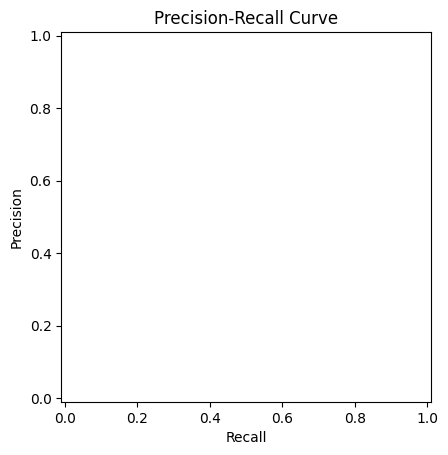

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
# Plot the PR curve
plt.figure()
PrecisionRecallDisplay(precision=precision['precision'], recall=recall['recall']).plot()
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()